# Plotting Trajectories
Author: Talia Borofsky  
Date:   Started 2/25/21  
Project: Static environments with limited resources select for multiple foraging strategies rather than conformity  
Description:
- This code plots trajectories for interesting paramater combinations. We first plot $u_1, u_2, r_1, r_2$ trajectories for a population entirely made up of the resident phenogenotype $AB$. Then we show trajectories of $p_1, p_2, r_1, r_2, x, u$ when allele $a$ invades and $p_1, p_2, r_1, r_2, y,u$ when $b$ invades.
- Data structures used are numpy arrays, tuples, lists, and dataframes loaded from csv files in the folder. 
- In particular, note that we use the program ternary to plot ternary plots

In [2]:
import numpy as np
#import importlib
from numpy import linalg
import PO_helperfuns
from PO_helperfuns import *
import PO_DatFrameFuns
from PO_DatFrameFuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
#import sympy as sp
from sympy import *
#from sympy.solvers import solve
#np.set_printoptions(precision=3, suppress = True)
#import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator

# for ternary plots
import ternary


# for formatting tick labels
#from matplotlib.ticker import FormatStrFormatter

#for parallelizing:
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

# display options so complex numbers look ok
pd.options.display.float_format = lambda x: '{:0.4f}'.format(np.real(x)) if np.imag(x)==0 else "{0.real:.4}+{0.imag:.4}j".format(x)

# To do list:

1. There are 4 eigenvalues, $\lambda_1^+, \lambda_1^-, \lambda_2^+, \lambda_2^-$. 
    1. For  $\lambda_1^+, \lambda_1^-$, I need to...
        1) Plot the discriminants in relation to $K, \pi_C, \beta$ 
        2) Plot the magnitudes $\lambda_1^+, \lambda_1^-$ separately in relation to $K, \pi_C, \beta$
    2. For $\lambda_2^+, \lambda_2^-$, I need to 
        1. Do what I did for $\lambda_1^+, \lambda_1^-$
        2. For $\lambda_2^+, \lambda_2^-$ values that are complex, plot their magnitude separately from real ones
        
2. Trajectory plots - use cartesian plots with time on the x axis
    1. For equilibria at which eigenvalues are complex, real and stable, or real and unstable, plot u1, u2, r1, r2 with time
    

## Eigenvalue Plotting functions

In [2]:
def MakeMesh(betavals,svals,mu):
    Bmesh, Smesh = np.meshgrid(betavals,svals) 
    norm = scs.norm(mu)
    Kmesh = Kfun(Smesh, norm)
    pcmesh = pcfun(Smesh,norm)
    u1mesh =  PredictEquilibrium_NoPref(Kmesh,pcmesh, Bmesh)
    return(Smesh, Bmesh,Kmesh,pcmesh,u1mesh)

def plot_discrim(ax, s,beta,discrim,which_lambda):
    if which_lambda==1:
        # want to go from the minimum value, rounded down to the first decimal place, to the max value,
        # rounded up to the first decimal place
        
        levels = np.arange(float(np.floor(np.min(discrim)*10))/10,
                           float(np.ceil(np.max(discrim)*10))/10 +0.1,
                          0.1)
        if len(levels)<5:
            levels = np.arange(float(np.floor(np.min(discrim)*10))/10,
                           float(np.ceil(np.max(discrim)*10))/10 +0.025,
                          0.025)
        cp = ax.contourf(s,beta,discrim, cmap = "RdYlBu", levels = levels)
    else:
        cp = ax.contourf(s,beta,discrim, cmap = "RdYlBu")
    cb = plt.colorbar(cp,ax=ax)
    cb.ax.yaxis.set_ticks_position('right')
    
    ax.set_xlabel(r'$s$', fontsize=20)
    ax.set_ylabel(r'$\beta$', fontsize = 20)
    
    return(cp)

def plot_mag(ax, s,beta, lamda):
    
    mag = np.abs(lamda)
    # need to choose appropriate levels for the range of values
    
    if np.max(mag) > 0.9:
        levels = np.arange(np.trunc(np.min(mag)*10)/10,1.2,0.1)
        cp = ax.contourf(s,beta,mag, levels=levels, cmap = "RdYlBu")
    else:
        cp = ax.contourf(s,beta,mag, cmap = "RdYlBu")
    cb = plt.colorbar(cp, ax = ax)
    cb.ax.yaxis.set_ticks_position('right')
    ax.set_xlabel(r'$s$', fontsize=20)
    ax.set_ylabel(r'$\beta$', fontsize = 20)
    
    
    return(cp)

def plot_lambda(s, beta, discrim,lam_minus,lam_plus,which_lambda):
    #get discriminant and lambdas


    fig =plt.figure(figsize=(16,12))
    
    #fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)
    X = [ (1,2,1), (2,2,2), (2,2,4) ]
    axes = [plt.subplot(nrows, ncols, plot_number) for nrows, ncols, plot_number in X]
    fig.subplots_adjust(hspace=0.3)
    
    p11, p12,p13 = [plot_discrim(axes[0],s,beta,discrim,which_lambda), plot_mag(axes[1],s,beta,lam_minus), 
                    plot_mag(axes[2],s,beta,lam_plus)]#

    #axes[0].set_title(r'Discriminant of $\lambda_1^+, \lambda_1^-$',loc = 'left',fontsize=20)
    #axes[1].set_title(r'Magnitude of $\lambda_1^-$',fontsize=20)
    #axes[2].set_title(r'Magnitude of $\lambda_1^+$',fontsize=20)
    
    fig.text(0.1,0.92, 'A)', fontsize = 24, fontweight='bold',va='top', ha='right')
    fig.text(0.52,0.92,'B)',fontsize = 24, fontweight='bold',va='top', ha='right')
    fig.text(0.52,0.5,'C)',fontsize = 24, fontweight='bold',va='top', ha='right')

    return(fig,axes)

'''
make_eigval_plots: Does step 1 in the to do list.For a mu value, 
plots discriminant and magnitudes of the first pair of eigenvalues and the second pair of eigenvalues separately
makes 2 figures, the first (for lambda_1) with 3 subplots, the second (for lambda_2) with 5 subplots
@ inputs; betavals, svals = vectors of unique beta and svals. mu = scalar
'''
def make_eigval_plots(betavals,svals, mu):
    s, beta, K, pc,u1 = MakeMesh(betavals,svals,mu)
    r1 = 1 - beta*u1
    R = 1 + r1
    L = K/2+pc
    W = 1 + pc +2*r1*L
    
    # lambda 1
    a1 = -W*R
    b1 = W
    c1 = 2*L*r1*u1*beta - L*r1*beta
    discrim1 = b1**2 - 4*a1*c1
    lam1_minus = (-b1 + np.lib.scimath.sqrt(discrim1))/(2*a1) # this is the smaller one because a1 < 0
    lam1_plus = (-b1 - np.lib.scimath.sqrt(discrim1))/(2*a1)
    
    
    
    # lambda 2
    a2 = -2*R*W*u1
    b2 = 2*W*u1 + K*R**2
    c2 = -K*R - 2*L*r1*u1*beta
    discrim2 = b2**2 - 4*a2*c2
    lam2_minus = (-b2 + np.lib.scimath.sqrt(discrim2))/(2*a2) # this is the smaller one because a1 < 0
    lam2_plus= (-b2 - np.lib.scimath.sqrt(discrim2))/(2*a2)
    
    
    
    fig1,axes1 = plot_lambda(s, beta, discrim1,lam1_minus,lam1_plus,1)
    fig2,axes2 = plot_lambda(s, beta, discrim2,lam2_minus,lam2_plus,2)
    eig1data = [discrim1, np.abs(lam1_minus),np.abs(lam1_plus)]
    eig2data = [discrim2, np.abs(lam2_minus), np.abs(lam2_plus)]
    return(fig1,axes1,fig2,axes2, eig1data, eig2data)


def plot_pts(sscatter,bscatter,fig1,axes1,fig2,axes2):
    annotations = ['a','b','c','d','e','f','g','h','i']
    annotations = annotations[0:len(sscatter)]
    def scatter_label(axes,sscatter,bscatter,annotations):
        for j,ax in enumerate(axes):
            ax.scatter(sscatter,bscatter,s=50,marker='o',c='k')
            for i, label in enumerate(annotations):
                if j == 0:
                    ax.annotate(label, xy=(sscatter[i], bscatter[i]-0.03),fontsize=16)
                else:
                    ax.annotate(label, xy=(sscatter[i], bscatter[i]-0.06),fontsize=16)
        
    scatter_label(axes1,sscatter,bscatter,annotations)
    scatter_label(axes2,sscatter,bscatter,annotations)

        
    return(fig1,fig2)

In [6]:
betavals = np.linspace(0,1,100)
svals = np.linspace(0,4,100)
muvals = np.array([-2,-1,0,1])

## $\mu = -2$

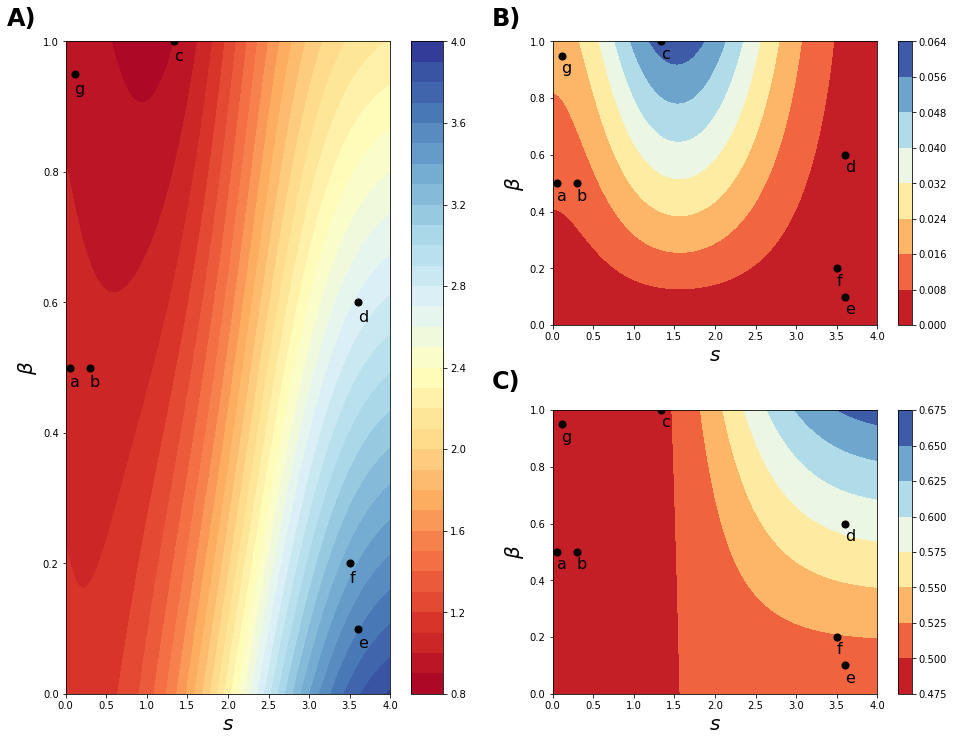

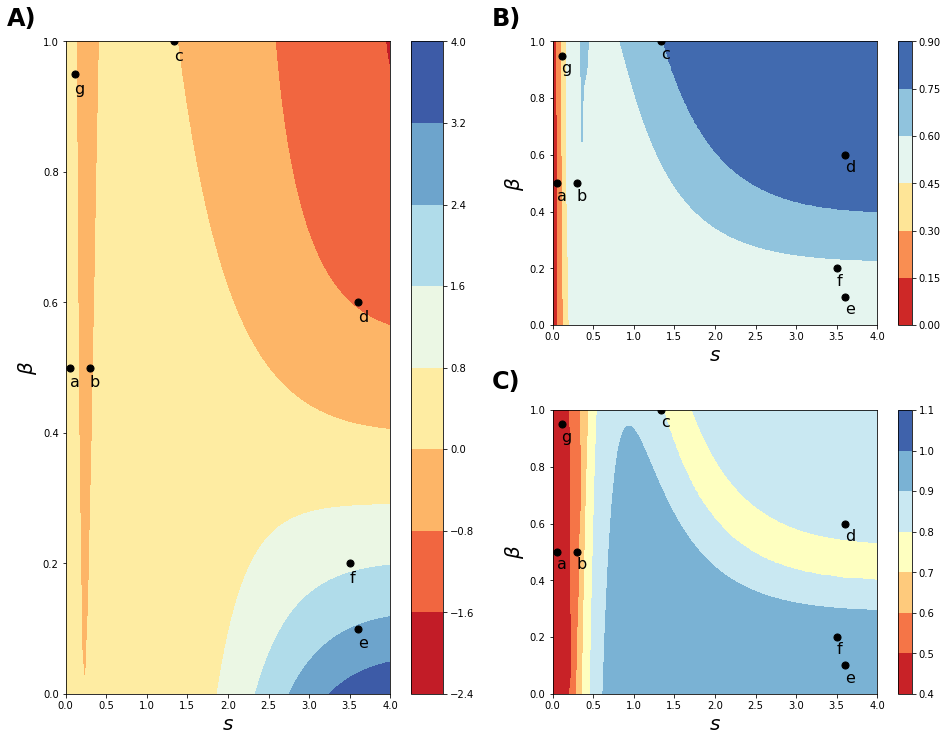

In [7]:
fig1,axes1, fig2,axes2, eig1data,eig2data = make_eigval_plots(betavals,svals, -2)
muval = -2
sscatter1 = [0.05,0.3,float(4)/3, 3.6, 3.6, 3.5, 0.11]
bscatter1 = [0.5,0.5,1,0.6,0.1,0.2, 0.95]
fig1, fig2 = plot_pts(sscatter1,bscatter1,fig1,axes1,fig2,axes2)
fig1.savefig('Figures/eigval1_mu_minus2',bbox_inches = 'tight')
fig2.savefig('Figures/eigval2_mu_minus2',bbox_inches = 'tight')

## $\mu = -1$

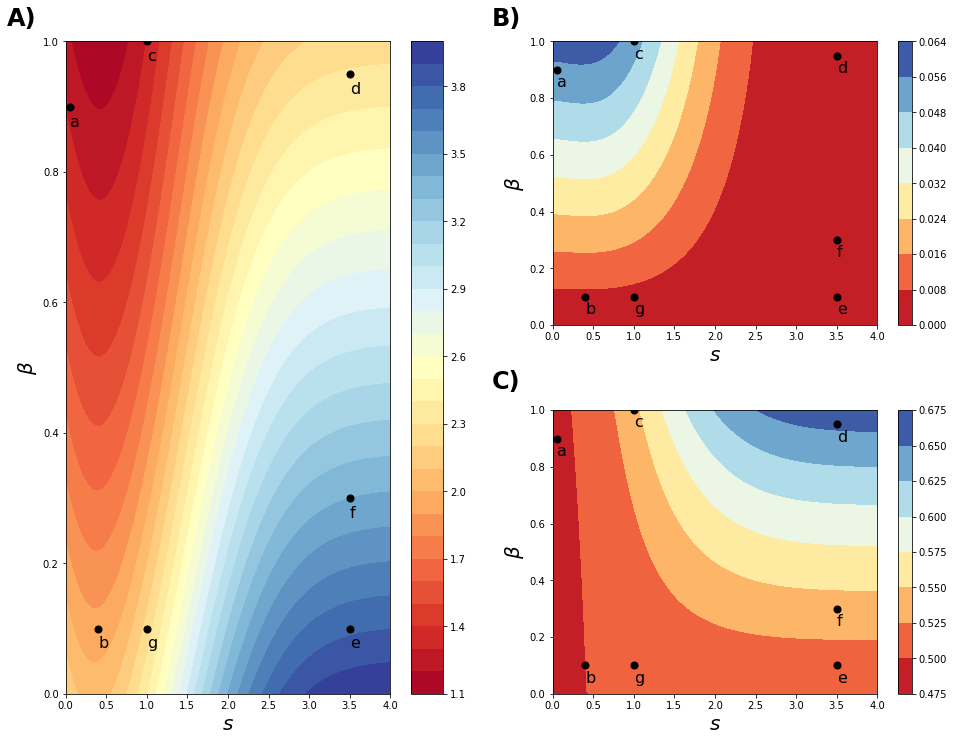

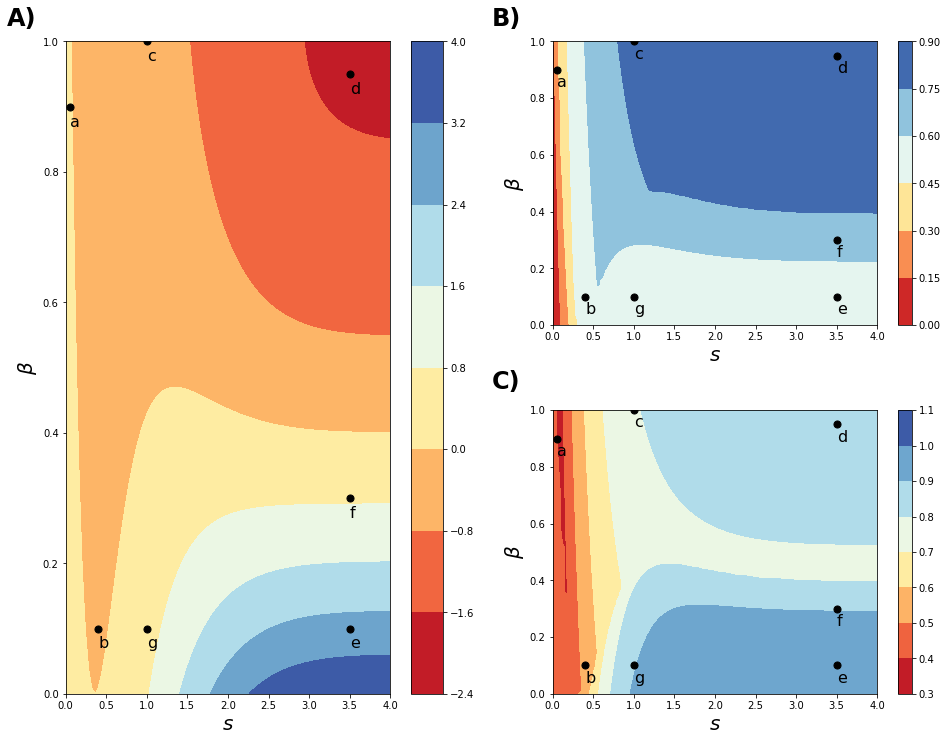

In [8]:
muval = -1
fig1,axes1, fig2,axes2, eig1data,eig2data = make_eigval_plots(betavals,svals, muval)

sscatter2 = [0.05,0.4, 1.0, 3.5,3.5,3.5,1.0]
bscatter2 = [0.9,0.1, 1.0, 0.95,0.1,0.3,0.1]

fig1, fig2 = plot_pts(sscatter2,bscatter2,fig1,axes1,fig2,axes2)


    
fig1.savefig('Figures/eigval1_mu_minus1',bbox_inches = 'tight')
fig2.savefig('Figures/eigval2_mu_minus1',bbox_inches = 'tight')

## $\mu = 0$

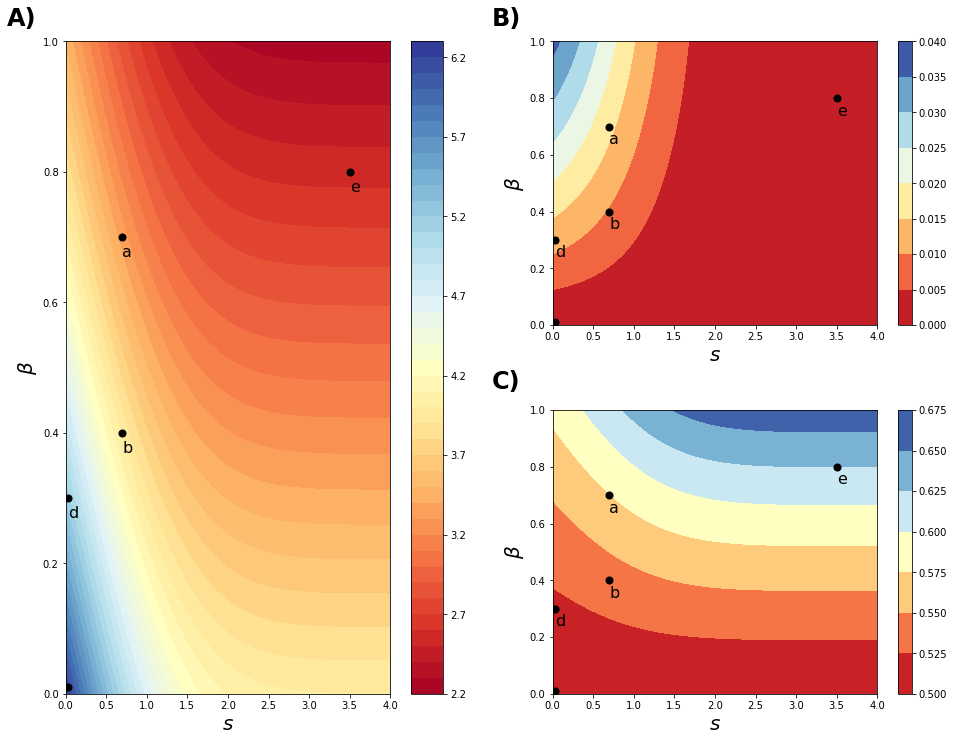

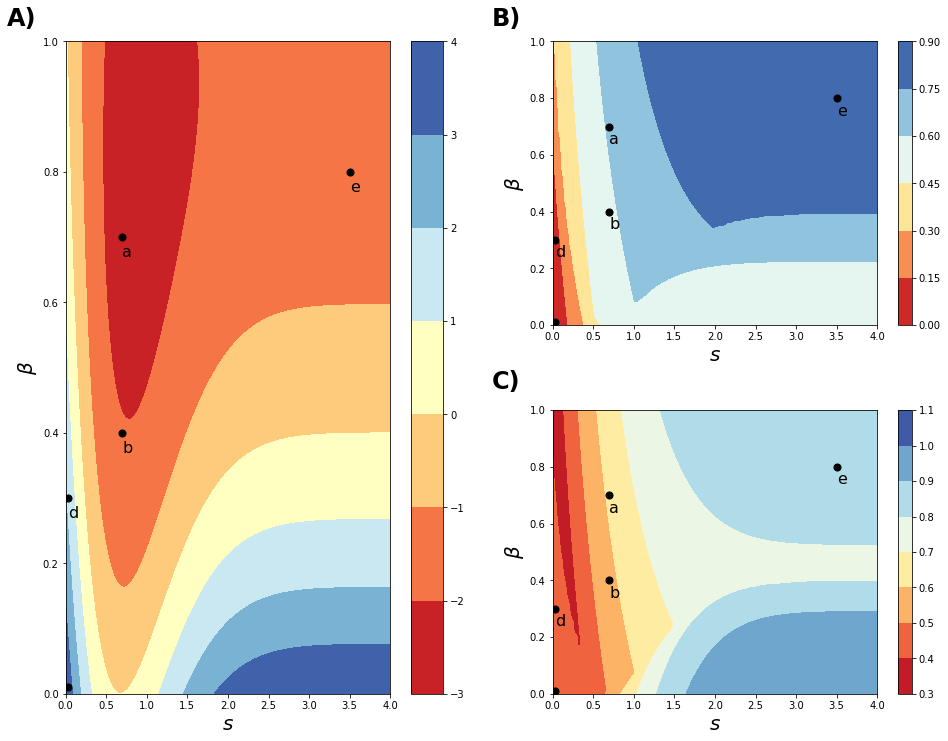

In [9]:
muval = 0
fig1,axes1, fig2,axes2, eig1data,eig2data = make_eigval_plots(betavals,svals, muval)

sscatter3 = [0.7, 0.7, 0.03, 0.03, 3.5]
bscatter3 = [0.7, 0.4, 0.01, 0.3, 0.8]
fig1, fig2 = plot_pts(sscatter3,bscatter3,fig1,axes1,fig2,axes2)


fig1.savefig('Figures/eigval1_mu_0',bbox_inches = 'tight')
fig2.savefig('Figures/eigval2_mu_0',bbox_inches = 'tight')

## $\mu = 1$

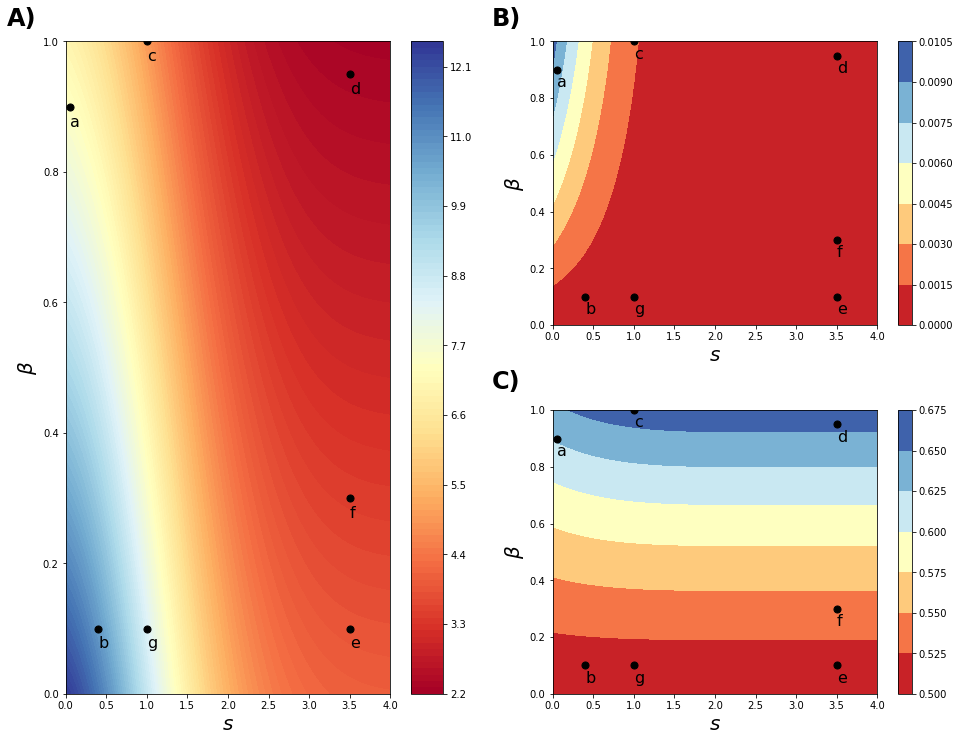

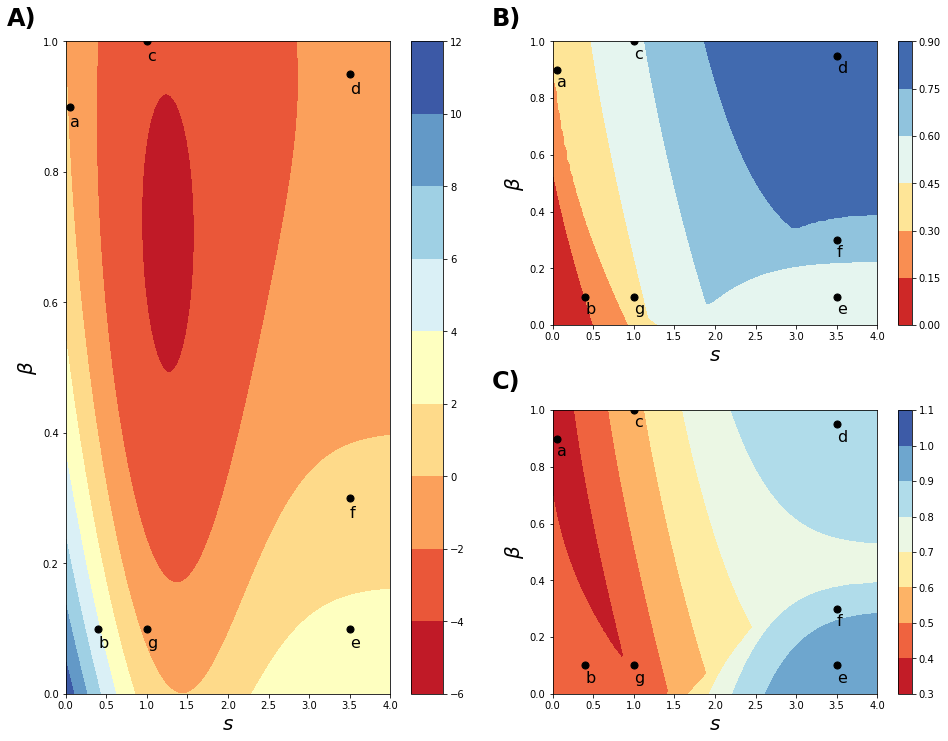

In [10]:
muval = 1
fig1,axes1, fig2,axes2, eig1data,eig2data = make_eigval_plots(betavals,svals, muval)

sscatter4 = [0.6, 0.03, 0.03, 3.5, 3.5, 0.03]
bscatter4 = [0.6, 0.01, 0.3, 0.8, 0.09, 0.18]
fig1, fig2 = plot_pts(sscatter2,bscatter2,fig1,axes1,fig2,axes2)
fig1.savefig('Figures/eigval1_mu_1',bbox_inches = 'tight')
fig2.savefig('Figures/eigval2_mu_1',bbox_inches = 'tight')

## Table of marked values

In [16]:
def display_checked_data(sscatter, bscatter,muval):
    letters = ['a','b','c','d','e','f','g','h','i']
    n = len(sscatter)
    labels = letters[0:n]
    checkdata = pd.DataFrame({'label':labels,'mu':muval,'s':np.around(sscatter,2), 'beta':bscatter})
    checkdata.sort_values(by=['s','beta'])
    Kvec = Kfun(checkdata.s, scs.norm(muval))
    pcvec = pcfun(checkdata.s, scs.norm(muval))
    u1vec = PredictEquilibrium_NoPref(Kvec,pcvec,checkdata.beta)
    checkdata['u1eq'] = np.around(u1vec,4)
    lambdavec = lambdastar(u1vec,1 - checkdata.beta*u1vec,Kvec,pcvec,checkdata.beta)
    lambdavec = np.around(lambdavec,4)
    checkdata['lam1_minus'] = lambdavec[0]
    checkdata['lam1_plus'] = lambdavec[1]
    checkdata['lam2_minus'] = lambdavec[2]
    checkdata['lam2_plus'] = lambdavec[3]
    return(checkdata)

def format_tab(x):
    if np.imag(x)==0:
        return('{:0.4f}'.format(np.real(x)))
    elif np.imag(x)>0:
        return("{0.real:.4}+{0.imag:.4}j".format(x))
    else:
        return("{0.real:.4}{0.imag:.4}j".format(x))

In [ ]:
t1 = display_checked_data(sscatter1, bscatter1,-2)
t2 = display_checked_data(sscatter2, bscatter2,-1)
t3 = display_checked_data(sscatter3, bscatter3,0)
t4 = display_checked_data(sscatter4, bscatter4,1)
t = t1.append([t2,t3,t4])
print(t.to_latex(index=False, 
                 float_format =lambda x: format_tab(x)))

In [ ]:
mu = 1; s = 3.5; beta = 0.09;
K = Kfun(s, scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
u1 = PredictEquilibrium_NoPref(K,pc,beta)
print('u1 = %0.10f'%u1)
eigs = lambdastar(u1,1-beta*u1, K,pc,beta)
print(eigs)

Check parts of generated dataframe that did not reach equilibrium

# Bifurcation Diagram

In [3]:
def lambdastar(u1,r1, K,pc,beta):
    R = 1 + r1
    L = K/2+pc
    W = 1 + pc +2*r1*L
    a1 = -W*R
    b1 = W
    c1 = 2*L*r1*u1*beta - L*r1*beta
    lamda1 = (-b1 + np.lib.scimath.sqrt(b1**2 - 4*a1*c1))/(2*a1)
    lamda2= (-b1 - np.lib.scimath.sqrt(b1**2 - 4*a1*c1))/(2*a1)
    
    a2 = -2*R*W*u1
    b2 = 2*W*u1 + K*R**2
    c2 = -K*R - 2*L*r1*u1*beta
    discrim2 = b2**2 - 4*a2*c2
    lamda3 = (-b2 + np.lib.scimath.sqrt(discrim2))/(2*a2) # this is the smaller one because a1 < 0
    lamda4= (-b2 - np.lib.scimath.sqrt(discrim2))/(2*a2)
    
    return([lamda1,lamda2,lamda3,lamda4])
def InternalStability(u1,r1,K,pc,beta):
    # get eigenvalues
    evals = lambdastar(u1,r1,K,pc,beta)
    evals = evals[2:3]
    #check which ones are complex
    
    #  list of 4 arrays, with size of each array being the number of parameter combos
    isComplex_mat = [np.iscomplex(lamda) for lamda in evals] 
    # condense into a vector, with an entry for each equilibrium
    isComplex = np.sum(np.array(isComplex_mat).astype(int),0)
    f_isComplex = np.vectorize(lambda x: "Complex" if x>0 else "Real")
    isComplex = f_isComplex(isComplex)
    #  list of 4 magnitude arrays, with size being the number of parameter combos
    lamda_mag = np.array([np.sqrt(np.real(lamda)**2 + np.imag(lamda)**2) for lamda in evals])
    # for each eigenvalue for each equilibrium, determine if mag >=1 (so equilibrium is internally unstable)
    maxmag = np.max(lamda_mag,0)
    classify = np.vectorize(lambda x: "Stable" if x < 1 else "Unstable" if x > 1 else "Inconclusive")
    Stability = classify(maxmag)
    
    return(isComplex, Stability)

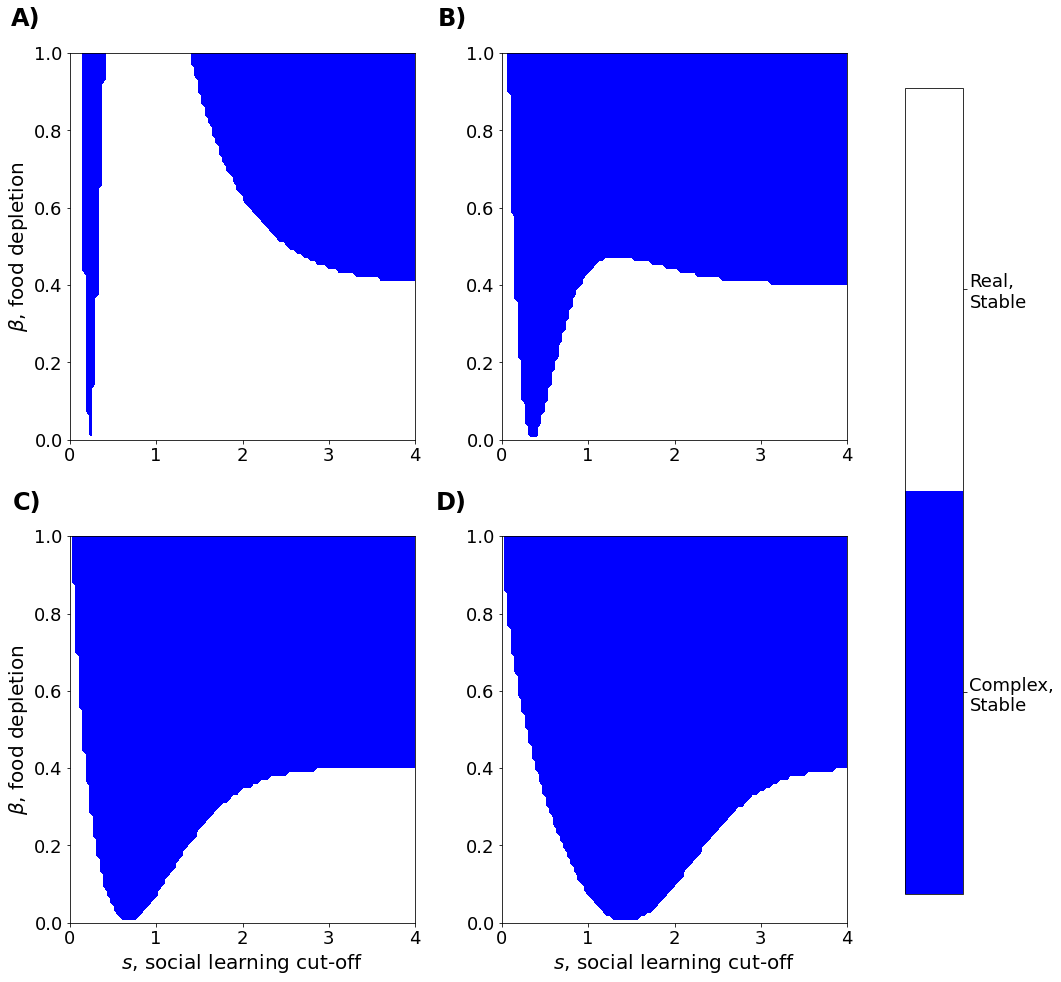

In [4]:
# for inside contour, want to indicate where complex and where unstable
# we proved (see appendix) that if the eigenvalue is real, than it's of mag. < 1
# so this works:

def inside_Contour(beta, s,mu):
    # find K and pc
    norm = scs.norm(mu)
    K = Kfun(s,norm)
    pc = pcfun(s,norm)
    
    # find u1
    u1 = PredictEquilibrium_NoPref(K,pc, beta)
    r1 = 1 - beta*u1
    # find eigenvalues and determine stability
    isComplex, Stability = InternalStability(u1,r1,K,pc,beta)
    
    # make a code
    mat = np.zeros(isComplex.shape, dtype = 'object')
    mask1 = (isComplex=="Complex") & (Stability=="Unstable")
    mat[mask1] = "Complex,\nUnstable"
    mask2 = (isComplex=="Complex") & (Stability=="Stable")
    mat[mask2] = "Complex,\nStable"
    mat[(isComplex=="Real") & (Stability=="Unstable")] = "Real,\nUnstable"
    mat[(isComplex=="Real") & (Stability=="Stable")] = "Real,\nStable"
    mat[Stability=="Inconclusive"] = "Inconclusive"
    
    dic = {"Complex,\nStable":0, "Real,\nStable":1}
    # dic = {"Inconclusive":0,"Complex,\nUnstable":1,"Complex,\nStable":2, 
    #        "Real,\nUnstable":3, "Real,\nStable":4}
    dicinv =  { val: key for key, val in dic.items()  }
    f = lambda x: dic[x]
    fv = np.vectorize(f)
    Z = fv(mat)
    Z = Z.astype(int)
    return(Z, dicinv)
    
muvals = [-2,-1,0,1]  
    
fig, axes = plt.subplots(2,2,figsize = (16,16))
betavals = np.linspace(0,1,100)
svals = np.linspace(0,4,100)
Bmesh,Smesh = np.meshgrid(betavals,svals)
classify_matvec = [0,0,0,0]
for i,ax in enumerate(axes.flatten()):
    Z, dicinv = inside_Contour(Bmesh,Smesh,muvals[i])
    classify_matvec[i] = Z
    #cp = ax.contourf(Smesh,Bmesh,Z , levels = [-0.5, 0.5,1.5,2.5,3.5,4.5], colors = ['magenta','blue','lightgreen','yellow','white'])
    cp = ax.contourf(Smesh,Bmesh,Z , levels = [-0.5, 0.5,1.5], colors = ['blue','white'])
    ax.tick_params(axis='both', which='major', labelsize=18)
    if i == 0 or i == 2:
        ax.set_ylabel(r'$\beta$'+", food depletion", fontsize = 20)
    if i > 1:
        ax.set_xlabel(r'$s$'+", social learning cut-off", fontsize = 20)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1])
cb.ax.set_yticklabels([dicinv[t] for t in [0,1]])
#for i, lab in enumerate(["real,\nstable", "complex, \nstable", "complex, \nunstable"]):
#    cb.ax.text(2.5, (3 * i ) / 3.0 -0.5, lab,  va='center', fontsize=18)
cb.ax.get_yaxis().labelpad = 15
labels = cb.ax.yaxis.get_ticklabels()
[l.set_fontsize(18) for l in labels]

fig.subplots_adjust(hspace=0.25,wspace = 0.25)

# add axis labels
fig.text(0.1,0.92, 'A)', fontsize = 24, fontweight='bold',va='top', ha='right')
fig.text(0.47,0.92,'B)',fontsize = 24, fontweight='bold',va='top', ha='right')
fig.text(0.1,0.5,'C)',fontsize = 24, fontweight='bold',va='top', ha='right')
fig.text(0.47,0.5,'D)',fontsize = 24, fontweight='bold',va='top', ha='right')
fig.savefig('Figures/PO_InternalContour.png')

# Load eigenvalues onto dataframe generated in PO_GenerateDFs.ipynb

In [ ]:
dat = pd.read_csv('data.csv')
isComplex, Stability = InternalStability(dat.u1eq,dat.r1eq,dat.K,dat.pc,dat.beta)
eigvals = lambdastar(dat.u1eq,dat.r1eq, dat.K,dat.pc,dat.beta)

#dat["InternStable"] = max_lstar < 1

dat["Internal_Complexity"]= isComplex
dat["Internal_Stability"] = Stability # 1 if stable, 0 if unstable, -1 if inconclusive
dat["lstar1"] = eigvals[0]
dat["lstar2"] = eigvals[1]
dat["lstar3"] = eigvals[2]
dat["lstar4"] = eigvals[3]

The eigenvalue's stability predictions mostly agree with iterations

 Except when $u_1 \neq u_2$, which happens when $\pi_C \approx 0$! Of course, my eigenvalues are calculated based on the assumption that $u_1 = u_2$. I don't understand why we find $u_1 \neq u_2$ when $\pi_C \approx 0$ because still $\pi_C > 0$.

In [ ]:
sum(((dat.Internal_Stability=="Stable") & (dat.reached_eq==False))&(np.abs(dat.u1eq - dat.u2eq)< 1e-10))



In [ ]:
mask = ((dat.Internal_Stability=="Stable") & (dat.reached_eq==False))&(np.abs(dat.u1eq - dat.u2eq)> 1e-10)

datweird = dat[mask]
datweird.drop(['u1init','u2init','buinit','r1init','r2init','URstable','Unnamed: 0'],axis=1)

In [ ]:
dat_unstable = dat.query('Internal_Stability =="Unstable"')
dat_unstable.drop(['u1init','u2init','buinit','r1init','r2init','URstable','Unnamed: 0'],axis=1)

We can see that wherever an eigenvalue is complex, it is not unstable

# Trajectory Plots

## Cartesian trajectory plots

In [ ]:


def get_init_pts(mu,s,beta):
    u1init = [0.05,0.48, 0.08, 0.6]
    u2init = [0.1,0.4,0.9, 0.3]
    buinit = 1 - np.array(u1init) - np.array(u2init)
    r1init = [0.5, 0.85, 0.2, 0.7]
    r2init = [0.1,  0.3,  0.9, 0.5]
    init_pts = get_param_grid(s,mu, beta)
    K = Kfun(s, scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    init_pts = pd.DataFrame({'mu':mu,'K': K, 'pc': pc,'s':s, 'beta': beta, 'u1init': u1init, 'u2init':u2init, 
            'buinit':buinit, 'r1init':r1init, 'r2init':r2init})
    u1eq = PredictEquilibrium_NoPref(K,pc,beta)
    init_pts['u1eq'] = u1eq
    init_pts['u2eq'] = u1eq
    init_pts['bueq'] = 1 - 2*u1eq
    init_pts['r1eq'] = 1 - beta*u1eq
    init_pts['r2eq'] = 1 - beta*u1eq
    init_pts['W'] = 1 + pc + 2*r1*(K/2 + pc)
    return(u1eq, init_pts)
# get initial points
def get_trajectory(row,tsteps):
    
    # assigning columns to variables for more readability
    K,pc,beta, u1, u2, bu, r1, r2 = np.transpose(*row[['K','pc','beta', 'u1init','u2init',
                                                       'buinit', 'r1init','r2init']].values)
    uvec = np.array([u1,u2,bu]); rvec = np.array([r1,r2])
    xvec = np.array([0,0,0])
    list_rows = []
    
    eq_pt = np.transpose(*row[['u1eq','u2eq','bueq','r1eq','r2eq']].values)
    for t in range(0,tsteps):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2],
                                 "r1":rvec[0], "r2": rvec[1],
                                 "tstep":t, "color":row.color})
        list_rows.append(curr_row)
        
        curr_pt = np.transpose(*curr_row[['u1','u2','bu','r1','r2']].values)
        #if np.allclose(curr_pt, eq_pt,rtol = 1e-6, atol = 1e-6):
        #    break
        dist = np.sqrt(np.sum((curr_pt - eq_pt)**2,axis=0)) 
        reached_eq = dist < 1e-6
        if reached_eq ==1:
            break
        else:
            uvec,xvec,rvec,W = NextGen(uvec,xvec,rvec,K,pc,beta)
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))
def plot_trajectories(mu,s,beta, tsteps=200, detail_plot_loc = 0, colors = ['r','c','m','k']):
    u1eq, init_pts = get_init_pts(mu,s,beta)
    init_pts['color'] = colors
    
    fig, axes = plt.subplots(2,2,figsize = (15,15))
    
    nrow = 4 #len(init_pts)
    row_list = np.array_split(init_pts,nrow)
    traj_df_list = [get_trajectory(row,tsteps) for row in row_list]
    
    for i, traj_df in enumerate(traj_df_list):
        label = "Trajectory %d"%i
        if tsteps < 100:
            marker = 'o'
        else:
            marker=''
        axes[0][0].plot(traj_df.tstep, traj_df.u1, color = colors[i], label = label, marker=marker)
        axes[0][1].plot(traj_df.tstep, traj_df.u2, color=colors[i], label = label,marker=marker)
        axes[1][0].plot(traj_df.tstep, traj_df.r1, color = colors[i], label = label,marker=marker)
        axes[1][1].plot(traj_df.tstep, traj_df.r2, color = colors[i], label = label,marker=marker)
    
    axes[0][0].hlines(u1eq,0,tsteps, linestyles = 'dotted', color = 'k')
    axes[0][0].set_title(r'$u_1$ trajectory', fontsize = 20)
    axes[0][0].set_ylabel(r'$u_1$', fontsize = 20)
    
    axes[0][1].hlines(u1eq,0,tsteps,linestyles='dotted',color='k')
    axes[0][1].set_title(r'$u_2$ trajectory', fontsize = 20)
    axes[0][1].set_ylabel(r'$u_2$', fontsize = 20)
    
    axes[1][0].hlines(1 - beta*u1eq,0,tsteps, linestyles = 'dotted', color = 'k')
    axes[1][0].set_title(r'$r_1$ trajectory', fontsize = 20)
    axes[1][0].set_ylabel(r'$r_1$', fontsize = 20)
    axes[1][0].set_xlabel('time steps', fontsize = 20)
    
    axes[1][1].hlines(1 - beta*u1eq,0,tsteps, linestyles = 'dotted', color = 'k')
    axes[1][1].set_title(r'$r_2$ trajectory', fontsize = 20)
    axes[1][1].set_ylabel(r'$r_2$', fontsize = 20)
    axes[1][1].set_xlabel('time steps', fontsize = 20)



    #axes.set_ylim([max(0,u1eq-0.05) ,min(1,u1eq+0.05)])
    
    if detail_plot_loc != 0:
        traj_detail_list = [traj_df[(traj_df.u1>u1eq-0.05)&(traj_df.u1<u1eq+0.05)] for traj_df in traj_df_list]
        sub_axes_1 = plt.axes(detail_plot_loc)
        tf = [max(traj_df.tstep) for traj_df in traj_detail_list]
        tf = max(tf)
        for i, traj_df in enumerate(traj_detail_list):
            sub_axes_1.plot(traj_df.tstep, traj_df.u1, color = colors[i])
            sub_axes_1.set_title('Trajectories near the equilibrium')
        
        sub_axes_1.hlines(u1eq,0,tf, linestyles='dotted',color='k')
    
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.subplots_adjust(right=0.8)
    fig.legend(handles, labels, loc = (0.802, 0.5), ncol=1, fontsize = 20)
    
    
    return(axes,u1eq, traj_df_list)



A weird value from generate df's

In [ ]:
dat = pd.read_csv('data.csv')
dat_weird = dat.query('reached_eq==False')
print('mu = ' + str(pd.unique(dat_weird['mu'])))
print('s = ' + str(pd.unique(dat_weird['s'])))
print('beta = ' + str(pd.unique(dat_weird['beta'])))

In [ ]:
mu = -2; s = 3; beta = 0
K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
colors = ['r','c','m','k']
detail_plot_loc = 0 # no detail plot
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=500000,
                                             detail_plot_loc = detail_plot_loc, colors = colors)
# do a detail plot 
# see https://stackoverflow.com/questions/13583153/how-to-zoomed-a-portion-of-image-and-insert-in-the-same-plot-in-matplotlib

fig = axes[0][0].figure
fig.savefig('Figures/trajectory_no_reach_eq',bbox_inches = 'tight')
#fig.savefig('Figures/trajectory_muminus2_s0_3_beta0_5',bbox_inches = 'tight')

### $\mu = -2$

In [ ]:
mu = -2; s = 0.3; beta = 0.5
K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
colors = ['r','c','m','k']
detail_plot_loc = [.2, .65, .2, .2]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=15,
                                             detail_plot_loc = detail_plot_loc, colors = colors)
# do a detail plot 
# see https://stackoverflow.com/questions/13583153/how-to-zoomed-a-portion-of-image-and-insert-in-the-same-plot-in-matplotlib

fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus2_s0_3_beta0_5',bbox_inches = 'tight')

In [ ]:
mu = -2; s = 0.05; beta = 0.5
detail_plot_loc = [.2, .65, .2, .2]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=10,
                                             detail_plot_loc = detail_plot_loc, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus2_s0_05_beta0_5',bbox_inches = 'tight')

### $\mu = -1$

In [ ]:
mu = -1; s = 3.5; beta = 0.1
K = Kfun(3.5,scs.norm(-1)); print(K)
pc = pcfun(3.5,scs.norm(-1)); print(pc)

In [ ]:
print('f')
mu = -1; s = 3.5; beta = 0.3
K = Kfun(3.5,scs.norm(-1)); print(K)
pc = pcfun(3.5,scs.norm(-1)); print(pc)

In [ ]:
#e
mu = -1; s = 3.5; beta = 0.1
detail_plot_loc = [.25, .7, .15, .15]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=1000,
                                             detail_plot_loc = 0, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus1_e',bbox_inches = 'tight')

In [ ]:
#f
mu = -1; s = 3.5; beta = 0.3
detail_plot_loc = [.25, .7, .15, .15]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=100,
                                             detail_plot_loc = 0, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus1_e',bbox_inches = 'tight')

In [ ]:
mu = -1; s = 3.5; beta = 0.1
detail_plot_loc = [.25, .7, .15, .15]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=100,
                                             detail_plot_loc = 0, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus1_e',bbox_inches = 'tight')

In [ ]:
#a
mu = -1; s = 0.05; beta = 0.9
detail_plot_loc = [.25, .7, .15, .15]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=10,
                                             detail_plot_loc = detail_plot_loc, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus1_a',bbox_inches = 'tight')

In [ ]:
#e
mu = -1; s = 3.5; beta = 0.1
detail_plot_loc = [.25, .7, .15, .15]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=100,
                                             detail_plot_loc = 0, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_muminus1_e',bbox_inches = 'tight')

### $\mu = 0$

In [ ]:
#c
mu = 0; s = 0.03; beta = 0.01
detail_plot_loc = [.25, .555, .15, .15]
axes, u1eq, traj_df_list = plot_trajectories(mu,s,beta, tsteps=12,
                                             detail_plot_loc = detail_plot_loc, colors = colors)
fig = axes[0][0].figure
fig.savefig('Figures/trajectory_mu0_e',bbox_inches = 'tight')

## Internal Stability

### Functions

In [ ]:
# functio make_internal_traj_plots
# Summary: 
#       Plots the trajectories of u1, u2, bu, r1, and r2 when u = 1, 
#       i.e. all individuals are resident type AB
# Parameters
#       init_pts: a dataframe that is a subset of the dataframe from data.csv that shows initial points,
#                 mode parameters, and final equilibrium. Parameters are the same for each initial point
#       colors: The colors corresponding to each row of the init_pts dataframe.
# Returns:
#       returns the axes and figure handles for the ternary plot and the cartesian plot
#       Also returns a dataframe of the trajectories
# Description:
#       u1,u2,bu are plotted in a ternary plot. 
#       r1 and r2 are plotted on a cartesian plot

def make_internal_traj_plots(init_pts, colors):
    # format axes and figures
    fig_u, tax = format_my_ternary() # initiates a ternary plot and formats axes
    fig_r, ax_r = format_cartesian_plot() # initiates cartesian plot and formats axes
    init_pts['color'] = colors # put in column for color
    
    # for each initial point, we find the trajectory and plot it
    # we want to record these trajectories. I'll make a dataframe of points for each trajectory, 
    # and then stack these dataframes into one master frame
    
    nrow = len(init_pts)
    row_list = np.array_split(init_pts,nrow)
    
    traj_df_list = [get_trajectory(row) for row in row_list]
    
    
    plot_my_traj_p(traj_df_list,fig_u,tax, init_pts)
    plot_my_traj_r(traj_df_list,init_pts,fig_r,ax_r)
    
    
    trajectories_df = pd.concat(traj_df_list) # makes a dataframe of all the trajectories
    # colnames = ["u1","u2","bu","r1","r2","timestep","color"]
    # trajectories_df = pd.DataFrame(trajectories_mat,columns = colnames)
    
    trajectories_df = pd.merge(left=trajectories_df, right=init_pts, 
                               on = 'color').sort_values(by=['color','tstep'])

    return(tax, fig_u, ax_r, fig_r, trajectories_df, traj_df_list)

# function format_my_ternary
# Summary: Sets up a ternary plot
# Parameters: None
# Returns: Handles to the figure and ternary axis
# Description:
#   Uses package ternary to create a ternary plot
#   Gets rid of the outer box and sets tick marks and axis labels
def format_my_ternary(if_internal = 1):
    scale = 1
    fig_u, tax = ternary.figure(scale=scale)
    
    # set up bounderize and size
    fig_u.set_size_inches(8,8)
    tax.boundary()
    
    # tick preferences
    tax.ticks(axis='lbr', multiple=.2, linewidth=1, 
              offset = 0.02, tick_formats = "%.1f"), 
    
    # turn off matplotlib's outer box and ticks
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Label corners - removed this for now
    if if_internal:
        rcl = r'$u_1$'
        tcl = r'$u_2$'
        lcl = r'$\bar{u}$'
    else:
        rcl = r'$p_1$'
        tcl = r'$p_2$'
        lcl = r'$\bar{p}$'
    fontsize = 20
    tax.right_corner_label(rcl, fontsize=fontsize, offset = 0.2)
    tax.top_corner_label(tcl, fontsize=fontsize, offset = 0.2)
    tax.left_corner_label(lcl, fontsize=fontsize, offset = 0.2)

    # Label sides
    #tax.left_axis_label(r'$\bar{u}$', fontsize = fontsize, offset=0.14)
    #tax.right_axis_label(r'$u_2$', fontsize = fontsize, offset=0.14)
    #tax.bottom_axis_label(r'$u_1$', fontsize = fontsize, offset=0.14)
    return(fig_u,tax)

def format_cartesian_plot(if_r = 1, zlabel = ""):
    
    fig, ax = plt.subplots(1,1,figsize = (6,6))
    if if_r:
        ax.set_xlabel(r'$r_1$', fontsize = 20)
        ax.set_ylabel(r'$r_2$', fontsize = 20)
    else:
        ax.set_xlabel(r'$u$', fontsize = 20)
        ax.set_ylabel(zlabel, fontsize = 20)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    #ax.legend(loc = 'best', fontsize = 14)
        #TO-DO// FILL IN


    return(fig,ax)

def get_trajectory(row):
    
    # assigning columns to variables for more readability
    K,pc,beta, u1, u2, bu, r1, r2 = np.transpose(*row[['K','pc','beta', 'u1init','u2init',
                                                       'buinit', 'r1init','r2init']].values)
    uvec = np.array([u1,u2,bu]); rvec = np.array([r1,r2])
    xvec = np.array([0,0,0])
    list_rows = []
    
    eq_pt = np.transpose(row[['u1eq','u2eq','bueq','r1eq','r2eq']].values)
    for t in range(0,200):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2],
                                 "r1":rvec[0], "r2": rvec[1],
                                 "tstep":t, "color":row.color})
        list_rows.append(curr_row)
        
        curr_pt = np.transpose(*curr_row[['u1','u2','bu','r1','r2']].values)
        if np.allclose(curr_pt, eq_pt,rtol = 1e-6, atol = 1e-6):
            break
        else:
            uvec,xvec,rvec,W = NextGen(uvec,xvec,rvec,K,pc,beta)
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))
        
    
def plot_my_traj_p(traj_df_list, fig_u, tax,init_pts = [], if_internal = 1):
    
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep")
        umat = traj_df[['u1','u2','bu']].values
        if if_internal==0:
            xmat = traj_df[['x1','x2','bx']].values
            pmat = umat + xmat 
        else:
            pmat = umat
                
        trajectory = list(map(tuple,pmat))
    #color = traj_df.color[0]               
        label = "Starting with IP %d"%(i+1) if if_internal else "Perturbation %d"%(i+1)
        tax.plot(trajectory, color = traj_df.color.values[0], label = label)
    
    if if_internal:
        # plot initial points as black squares
        init_u_pts = list(map(tuple, init_pts[['u1init','u2init','buinit']].values ))
        tax.scatter(init_u_pts, marker='s', color='k', label="Initial Points")
        
#        K = pd.unique(init_pts.K)[0]; pc = pd.unique(init_pts.pc)[0]; beta = pd.unique(init_pts.beta)[0]
#        u1eq = PredictEquilibrium_NoPref(K,pc,beta)
#        eqlabel = 'equilibrium' 
#        tax.scatter((u1eq, u1eq, 1 - 2*u1eq), marker = '*', color = 'k', label = eqlabel, s = 200)

    tax.legend(loc="best", fontsize=14)
    tax.resize_drawing_canvas(scale=1.05)
    

    return(1)
"""
Iterates from an initial point until the iteration approximately reaches equilibrium

Parameters
----
row 
    - a row from the init_pts dataframe.

Returns
----
    traj_df -  a dataframe with the values of u1, u2, bu, r1, r2 
        for each time step until they reach the equilibrium
"""
def plot_my_traj_r(traj_df_list,init_pts,fig_r,ax_r, if_internal = 1):
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep") # sorting just in case
        r1vec = traj_df.r1
        r2vec = traj_df.r2
        if if_internal:
            ax_r.plot(r1vec, r2vec, color = traj_df.color.values[0], label = "Starting with IP %d"%(i+1))
        else:
            ax_r.plot(r1vec, r2vec, color = traj_df.color.values[0], label = "Perturbation %d"%(i+1))
    
    # plot initial points as black squares
    if if_internal:
        r1init = init_pts.r1init.values
        r2init = init_pts.r2init.values
        ax_r.scatter(r1init, r2init, marker='s', color='k', label="Initial Points")
    
        # plot equilibrium(a)
        K = pd.unique(init_pts.K)[0]; pc = pd.unique(init_pts.pc)[0]; beta = pd.unique(init_pts.beta)[0]
        u1eq = PredictEquilibrium_NoPref(K,pc,beta)
        r1eq = 1 - beta*u1eq
        r2eq = 1 - beta*u1eq
        eqlabel = 'equilibrium' 
        ax_r.scatter(r1eq, r2eq, marker = '*', color = 'k', label = eqlabel, s = 200)
   
    #ax_r.legend(loc = "best", fontsize=14)
    return(1)


In [ ]:
"""
make_external_traj_plots (row, colors)

Plots the trajectories after perturbing in the x or y direction. Plots:
    (1) a ternary plot of p1, p2, bp, 
    (2) a cartesian plot of r1, r2
    (3) a cartesian plot of u - z (z is a stand-in for x or y)
---
Parameters
    row: a row from the UniqueEquilibria dataframe
    ds: change in s. If not introducing allele a, then ds = 0
    dD: change in D. If not introducing allele b, then dD = 0.
---
Returns:
    tax_p, fig_p = axis and figure for ternary plot of p1, p2, bp
    ax_r, fig_r = axis and figure of plot of r1-r2
    ax_uz, fig_uz = axis and figure of plot of u - z
    trajectories_df: dataframe of u1,u2,bu,r1,r2,z1,z2,bz values for each time point, labeled by which perturbation
"""
def make_external_traj_plots(row, ds, dD, colors):
    # format axes and figures
    fig_p, tax_p = format_my_ternary(if_internal = 0) # initiates a ternary plot and formats axes
    fig_r, ax_r = format_cartesian_plot(if_r = 1) # initiates cartesian plot and formats axes
    zlabel = r'$x$' if ds!= 0 else r'$y$'
    fig_uz, ax_uz = format_cartesian_plot(if_r = 0, zlabel = zlabel) 
    
    
    perturb_list = Perturb(row)
    
    traj_df_list = [get_trajectory_external(row, perturbation, color, ds, dD) for perturbation, 
                    color in zip(perturb_list, colors)]
    
    plot_my_traj_p(traj_df_list, fig_p, tax_p, if_internal = 0)
    plot_my_traj_r(traj_df_list,row,fig_r,ax_r, if_internal = 0)
    
    plot_my_traj_uz(traj_df_list,row, fig_uz, ax_uz)
    trajectories_df = []
    trajectories_df = pd.concat(traj_df_list) # makes a dataframe of all the trajectories    
    trajectories_df = trajectories_df.sort_values(by=['color','tstep'])

    return(tax_p, fig_p, ax_r, fig_r, ax_uz, fig_uz, trajectories_df)
"""
Perturb

Finds valid perturbations for a set of equilibria (i.e. perturbations that won't result in invalid frequencies)
---
Parameters
    row
---
Returns
    list of perturbations in the u -direction, the z direction (stand-in for x or y... i know it's confusing),
and the r direction
"""
def Perturb(row):
    u1eq, u2eq, bueq, r1eq, r2eq = np.transpose(*row[['u1eq','u2eq','bueq', 'r1eq','r2eq']].values)
    # use dyvec here but dxvec could work too
    uvec = [u1eq, u2eq, bueq]
    rvec = [r1eq, r2eq]
    # get new post-perturb vectors
    du = 0.01
    change_u_1 = -du*np.array([0.015, 0.11, 1 - 0.015 - 0.11])
    change_u_2 = -du*np.array([0.29, 0.49, 1 - 0.29 - 0.49])
    change_u_3 = -du*np.array([0.49, 0.51, 1 - 0.51 - 0.49])
    change_u_4 = -du*np.array([0.9,0.05, 0.05])
    change_u_list = [Perturb_EdgeCase(uvec,duvec) for duvec in [change_u_1, change_u_2,
                                                                change_u_3, change_u_4]]
    change_u_1, change_u_2, change_u_3, change_u_4 = change_u_list
    
    dz = 0.01
    new_z_1 = dz*np.array([0.05,0.1, 1 - 0.05 - 0.1])
    new_z_2 = dz*np.array([0.48, 0.5, 1 - 0.48 - 0.5])
    new_z_3 = dz*np.array([0.9, 0.04, 0.06])
    new_z_4 = dz*np.array([0.3,0.6,1 - 0.9])
    
    dr = 0.01
    change_r_1 = dr*np.array([1,0.9])
    change_r_2 = dr*np.array([0.5,-0.3])
    change_r_3 = dr*np.array([-1,0.99])
    change_r_4 = dr*np.array([-0.2, -0.8])
    change_r_list = [Perturb_EdgeCase_r(rvec, drvec) for drvec in [change_r_1,change_r_2,
                                                                 change_r_3, change_r_4]]
    [change_r_1, change_r_2, change_r_3, change_r_4] = change_r_list
    
    return([change_u_1, new_z_1, change_r_1], [change_u_2, new_z_2, change_r_2],
          [change_u_3, new_z_3, change_r_3], [change_u_4, new_z_4, change_r_4])
    
    # now get new post-perturbation vectors
        
    
"""
Perturb_EdgeCase

    Adjusts the direction of a perturbation to account for cases where u_1 = 0, u_2 = 0, or bu = 0
    ---
    Parameters
        uvec - 3-vector (np.array) of the equilibrium u1, u2, bu values
        duvec - 3-vector (np.array) of delta_(u_1), delta_(u_2), delta_(ubar)
    ---
    Returns
        duvec - the original duvec adjusted so we do not perturb u1, u2, bu over a boundary
"""
def Perturb_EdgeCase(uvec,duvec):
    #recursively checks for edge cases so i don't get an invalid frequency. Adjusts duvec if needed
    
    # make sure using numpy arrays
    du = sum(duvec)
    uvec = np.array(uvec); duvec = np.array(duvec);
    # find locations of edge cases
    edge_bool = uvec + duvec <= 0
    
    n = sum(edge_bool)
    if n>0:
        duvec[edge_bool] = -uvec[edge_bool] +0.00001 # so not at exactly 0
        du_remain = du - sum(duvec)
        duvec[~edge_bool] = duvec[~edge_bool] + (1/np.float64(3-n))*du_remain
        
        # make sure that we didn't cause a different frequency to be negative:
        return(Perturb_EdgeCase(uvec,duvec))

    else:
        return(duvec)
"""
Perturb_EdgeCase

    Adjusts the direction of a perturbation to account for cases where r_i = 0 or 1
    ---
    Parameters
        rvec - 2-vector of the equilibrium r1, r2 values
        drvec - 2-vector of delta_(r_1), delta_(r_2)
    ---
    Returns
        drvec - the original drvec adjusted so we do not perturb r1, r2 over a boundary
"""
def Perturb_EdgeCase_r(rvec,drvec):
    #recursively checks for edge cases so i don't get an invalid frequency. Adjusts duvec if needed
    
    # make sure using numpy arrays
    rvec = np.array(rvec); drvec = np.array(drvec);
    # find locations of edge cases
    edge_bool_0 = rvec + drvec <= 0 
    edge_bool_1 = rvec + drvec >= 1
    edge_bool = edge_bool_0 + edge_bool_1
    drvec[edge_bool] = -drvec[edge_bool] # just change the direction of the perturbation
    return(drvec)
    


"""
get_trajectory

Perturbs the (former) equilibrium in a given direction and records the trajectory
---
Parameters
    row
    direction - a list of (np.array) vectors: 
        - a 3-vector of change i u_1, u_2, and bar u values
        - a 3-vector of x values and a 3-vector of y-values
        - a 2 vector of change in r_1, r_2 values
    ds
        delta_s value of allele $a$. set to 0 if not introducing $a$
    dD
        delta_D value of allele $b$. set to 0 if not introducing $b$
---
Returns
    traj_df, a dataframe with 
        - u1,u2,bu,r1,r2,x1,x2,bx,y1,y2,by values
        - W values
        - columns for time step, 
        - delta_s value (same for each row), delta_D value (same for each row), and color (same for each row)

"""
def get_trajectory_external(row, perturbation, color, ds, dD):
    
    # assigning columns to variables for more readability
    s,mu,K,pc,D,beta,W, u1, u2, bu, r1, r2 = np.transpose(*row[['s','mu','K','pc','D','beta','Weq', 'u1eq','u2eq',
                                                       'bueq', 'r1eq','r2eq']].values)
    [duvec, dzvec, drvec] = perturbation
    uvec = np.array([u1,u2,bu]) + duvec; 
    xvec = dzvec if ds !=0 else np.array([0,0,0]); 
    yvec = dzvec if dD != 0 else np.array([0,0,0])
    rvec = np.array([r1,r2]) + drvec
    
    # calculate dk and d_(pi_C)
    norm = scs.norm(mu,1)
    dk = Kfun(s + ds, norm) - K
    dpc = pcfun(s + ds, norm) - pc
    
    list_rows = []
    for t in range(0,200000):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2], 
                                 "x1":xvec[0], "x2": xvec[1], "bx": xvec[2],
                                 "y1":yvec[0], "y2": yvec[1], "by": yvec[2],
                                 "r1":rvec[0], "r2": rvec[1], "W": W,
                                 "tstep":t, "color":color, "ds":ds, "dD":dD},
                                index=[t])
        list_rows.append(curr_row)
        curr_pt = np.transpose(*curr_row[['u1','u2','bu','x1','x2','bx','y1','y2','by','r1','r2']].values)
        if t>1:
            if np.allclose(curr_pt, old_pt,rtol = 1e-10, atol = 1e-10):
                break
        uvec,xvec,yvec,rvec,W = NextGen(uvec,xvec,yvec,rvec,D,K,pc,beta, [dD, dk, dpc])
        old_pt =  curr_pt
            
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))


def plot_my_traj_uz(traj_df_list,row, fig_uz, ax_uz):
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep") # sorting just in case
        u = traj_df.u1 + traj_df.u2 + traj_df.bu
        x = traj_df.x1 + traj_df.x2 + traj_df.bx
        ax_uz.plot(u.values, x.values, color = traj_df.color.values[0], label = "Perturbation %d"%(i+1))
    
    # plot initial points as black squares
    
   
    #ax_r.legend(loc = "best", fontsize=14)
    return(1)

### Load DataFrames

In [ ]:
#dat = pd.read_csv('data.csv')
dat_unstable = dat.query('reached_eq == False')
dat_complex = dat.query('Internal_Complexity=="Complex"')




In [ ]:
dat_unstable

# Social Learning and learning Success

In [8]:
def MakeMesh(betavals,svals,mu):
    Bmesh, Smesh = np.meshgrid(betavals,svals) 
    norm = scs.norm(mu)
    Kmesh = Kfun(Smesh, norm)
    pcmesh = pcfun(Smesh,norm)
    u1mesh =  PredictEquilibrium_NoPref(Kmesh,pcmesh, Bmesh)
    return(Smesh, Bmesh,Kmesh,pcmesh,u1mesh)


muvals = np.arange(-1,1,0.5)
svals = np.arange(0,4,0.1)
betavals = [0,0.333, 0.6666, 1]

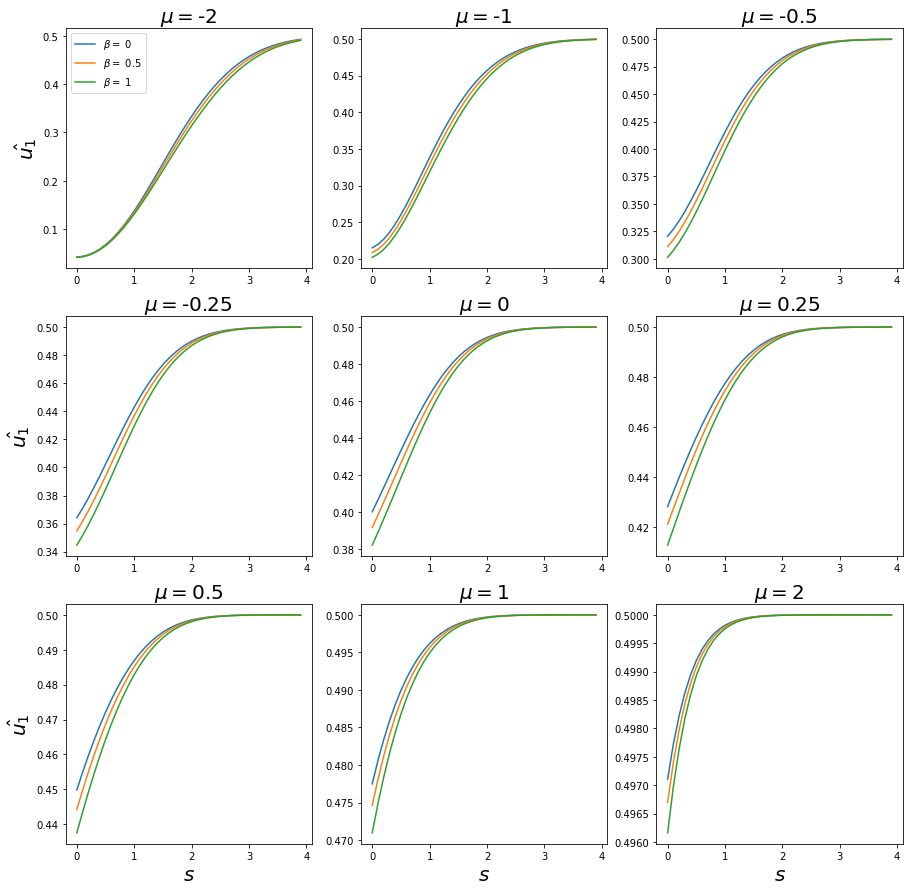

In [3]:
f, axs = plt.subplots(3,3,figsize=(15,15))

muvals = [-2,-1,-0.5,-0.25,0,0.25,0.5,1,2]
svals = np.arange(0,4,0.1)
K = np.array([Kfun(svals,scs.norm(mu)) for mu in muvals])
pc = np.array([pcfun(svals,scs.norm(mu)) for mu in muvals])
betavals = [0,0.5, 1]
for j,ax in enumerate(axs.flatten()):
    mu = muvals[j]
    Kvec = K[j]
    pcvec = pc[j]
    for i,beta in enumerate(betavals):
        u1 = PredictEquilibrium_NoPref(Kvec,pcvec,beta)
        lab = r'$\beta = $ ' + str(beta)
        ax.plot(svals,u1, label = lab)
    t = r'$\mu = $' + str(mu)
    ax.set_title(t, fontsize = 20)
axs[0][0].legend()
axs[0][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[1][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[2][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[2][0].set_xlabel(r'$s$', fontsize = 20)
axs[2][1].set_xlabel(r'$s$', fontsize = 20)
axs[2][2].set_xlabel(r'$s$', fontsize = 20)
f.savefig('Figures/u1_s_curve.png',bbox_inches = 'tight')

This is weird. I know that $K$ is symmetric with respect to $\mu$. But why is $\hat{u_1}$ symmetric about $\mu$?

Say we have a value $\hat{u_1}^{(0)}$ at $\mu = - \mu^{(0)}$. We want to prove that the value of $\hat{u_1}^{(1)}$ at $\mu = \mu^{(0)}$ is $\hat{u_1}^{(1)} = \hat{u_1}^{(0)}$

$\pi_c^{(1)} = \pi_w^{(0)} = 1 - K^{(0)} - \pi_c^{(0)}$

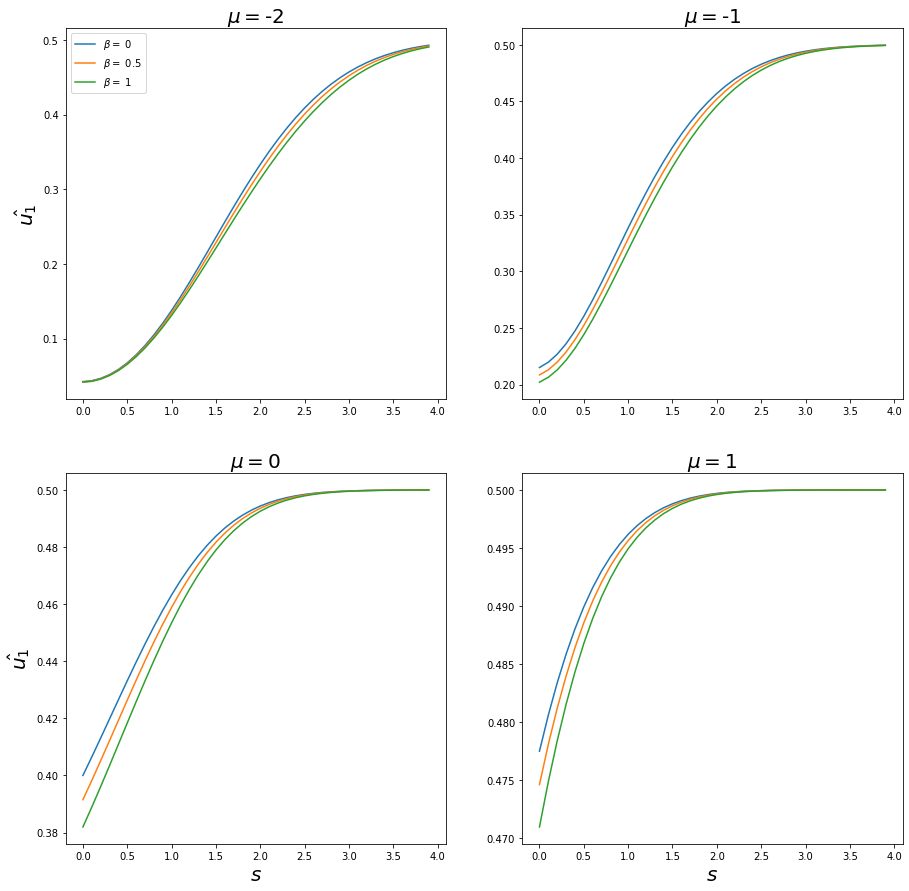

In [5]:
muvals = [-2,-1,0,1]
f, axs = plt.subplots(2,2,figsize=(15,15))
K = np.array([Kfun(svals,scs.norm(mu)) for mu in muvals])
pc = np.array([pcfun(svals,scs.norm(mu)) for mu in muvals])
betavals = [0,0.5, 1]
for j,ax in enumerate(axs.flatten()):
    mu = muvals[j]
    Kvec = K[j]
    pcvec = pc[j]
    for i,beta in enumerate(betavals):
        u1 = PredictEquilibrium_NoPref(Kvec,pcvec,beta)
        lab = r'$\beta = $ ' + str(beta)
        ax.plot(svals,u1, label = lab)
    t = r'$\mu = $' + str(mu)
    ax.set_title(t, fontsize = 20)
axs[0][0].legend()
axs[0][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[1][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[1][0].set_xlabel(r'$s$', fontsize = 20)
axs[1][1].set_xlabel(r'$s$', fontsize = 20)
f.savefig('Figures/u1_s_curve_4x4.png',bbox_inches = 'tight')

Text(0.5, 0, '$\\mu$')

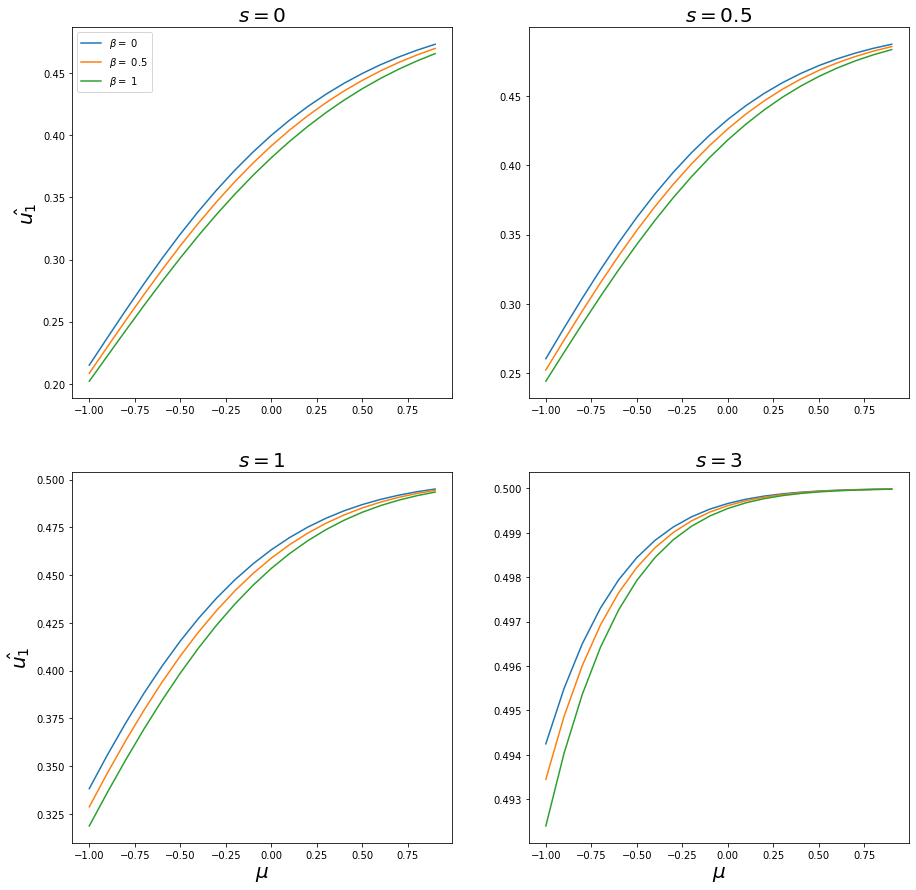

In [73]:
svals = [0,0.5,1,3]
muvals = np.arange(-1,1,0.1)
f, axs = plt.subplots(2,2,figsize=(15,15))
K = np.array([Kfun(s,scs.norm(muvals)) for s in svals])
pc = np.array([pcfun(s,scs.norm(muvals)) for s in svals])
betavals = [0,0.5, 1]
for j,ax in enumerate(axs.flatten()):
    s = svals[j]
    Kvec = K[j]
    pcvec = pc[j]
    for i,beta in enumerate(betavals):
        u1 = PredictEquilibrium_NoPref(Kvec,pcvec,beta)
        lab = r'$\beta = $ ' + str(beta)
        ax.plot(muvals,u1, label = lab)
    t = r'$s = $' + str(s)
    ax.set_title(t, fontsize = 20)
axs[0][0].legend()
axs[0][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[1][0].set_ylabel(r'$\hat{u_1}$', fontsize = 20)
axs[1][0].set_xlabel(r'$\mu$', fontsize = 20)
axs[1][1].set_xlabel(r'$\mu$', fontsize = 20)